In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import make_plots, load_data, extract_regions, split_data

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# Data Option 1: Load LHCO data

In [ ]:
features_sig=pd.read_hdf("/LHCO/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/LHCO/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [4]:
dataset_bg=load_data(features_bg)
dataset_sig=load_data(features_sig)

SR_low = 3.3
SR_high = 3.7
SB_low = 2.4
SB_high = 4.6

SR, SB = extract_regions(SR_low, SR_high, SB_low, SB_high, dataset_bg, dataset_sig)
(X_bg_SR, X_sig_SR) = SR
(X_bg_SB, X_sig_SB) = SB

In [5]:
X_train, X_bg_test = split_data(X_bg_SR) ## all background
y_train = np.zeros(len(X_train))

y_bg_test = np.zeros(len(X_bg_test))
X_sig = X_sig_SR ## all signal
y_sig = np.ones(len(X_sig))

X_test = np.concatenate((X_bg_test, X_sig))
y_test = np.concatenate((y_bg_test, y_sig))

# Data Option 2: 1D Gaussian Example

In [31]:
# Note this is a simple 1D example
var = 1
mu_bg = 0
mu_anom = 1
n = 500

X_bg = np.random.normal(mu_bg, var, size=(3*n,1))
y_bg = np.zeros(n)

X_anom = np.random.normal(mu_anom, var, size=(n,1))
y_anom = np.ones(n)

X_train = X_bg[0:2*n] # Train on background only
X_test = np.hstack((X_bg[2*n:], X_anom)) # Test on background and anomaly

y_train = np.hstack((y_bg, y_bg))
y_test = np.hstack((y_bg, y_anom))

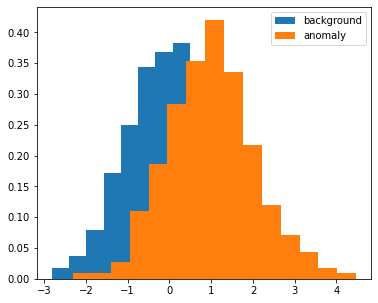

In [32]:
# Visualize data
plt.figure(figsize=(6,5))
plt.hist(X_bg, bins=15, density=True, label="background")
plt.hist(X_anom, bins=15, density=True, label="anomaly")
plt.legend()
plt.show()

# Autoencoder

In [6]:
from models.autoencoder import autoencoder, reconstruction_error

In [7]:
autoencoders = [autoencoder() for _ in range(5)]
histories = [ae.fit(X_train, X_train, epochs=1) for ae in autoencoders]
autoencoder_scores = [reconstruction_error(ae, X_test) for ae in autoencoders]

2022-11-18 00:43:38.849093: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3034/3034 [==============================] - 7s 2ms/step - loss: 0.0169


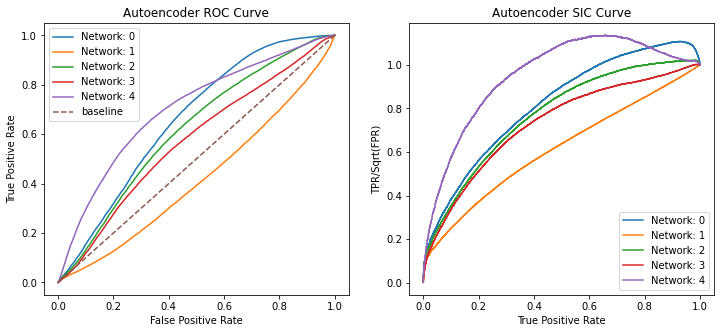

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, autoencoder_scores, y_test, "Autoencoder")
fig.show()

# OCD

In [9]:
from models.ocd import OCD

In [12]:
ocds = [OCD() for _ in range(5)]
histories = [ocd.fit(X_train, y_train, epochs=2) for ocd in ocds]
ocd_scores = [ocd.predict(X_test) for ocd in ocds]

Epoch 1/2
3034/3034 [==============================] - 3s 892us/step - loss: 0.0012 - accuracy: 1.0000
Epoch 2/2
3034/3034 [==============================] - 3s 895us/step - loss: 3.5917e-10 - accuracy: 1.0000
Epoch 1/2
3034/3034 [==============================] - 3s 898us/step - loss: 0.0023 - accuracy: 0.9993
Epoch 2/2
3034/3034 [==============================] - 3s 1ms/step - loss: 6.2216e-10 - accuracy: 1.0000
Epoch 1/2
3034/3034 [==============================] - 3s 884us/step - loss: 0.0016 - accuracy: 0.9997
Epoch 2/2
3034/3034 [==============================] - 3s 887us/step - loss: 1.6258e-09 - accuracy: 1.0000
Epoch 1/2
3034/3034 [==============================] - 3s 899us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 2/2
3034/3034 [==============================] - 3s 885us/step - loss: 3.8756e-10 - accuracy: 1.0000
Epoch 1/2
3034/3034 [==============================] - 3s 895us/step - loss: 0.0011 - accuracy: 1.0000
Epoch 2/2
3112/3112 [==============================] - 1s 4

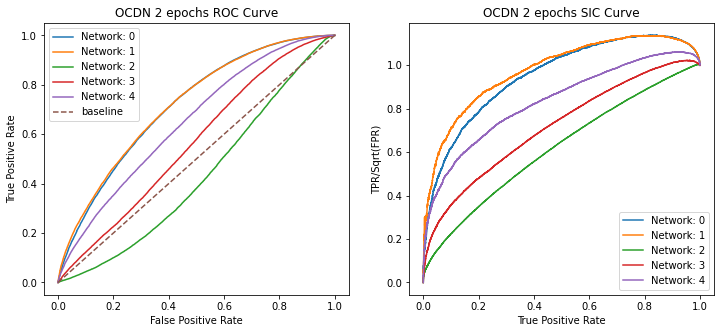

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, ocd_scores, y_test, "OCDN 2 epochs")
fig.show()

# OC-SVM

In [14]:
from models.oc_svm import OAD, IAD

In [15]:
# warning: This code chunk takes a while to run
oad = OAD()
iad = IAD()

oad.fit(X_train)
iad.fit(X_train)

IAD()

In [16]:
oad_scores = oad.scores(X_test)
iad_scores = iad.scores(X_test)

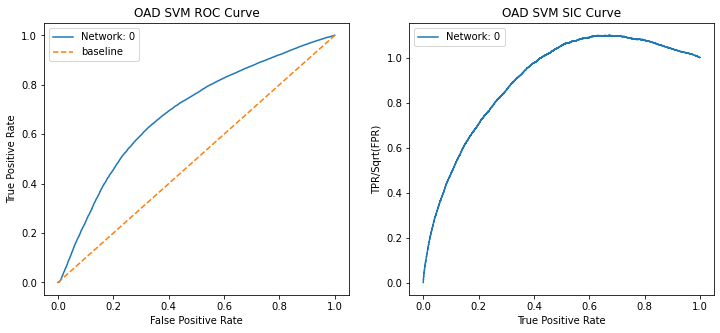

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, [1-oad_scores], y_test, "OAD SVM")
fig.show()

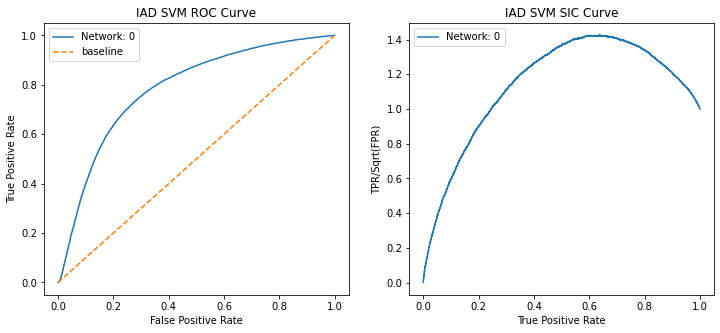

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, [iad_scores], y_test, "IAD SVM")
fig.show()

# Deep SVDD
Note: Displayed plots were run on the 1D gaussian example

In [20]:
import sys
sys.path.append('./models/DeepSVDD/Deep-SVDD-PyTorch/src')
from deepSVDD import DeepSVDD
import torch
from torch.utils.data import DataLoader

In [ ]:
# Deep SVDD Requires Train Loaders
def make_torch_data_loader(data1, label1, data2=[], label2=None, shuffle=True, batch_size=50):
    
    data1 = torch.Tensor(data1)
    data2 = torch.Tensor(data2)
    
    data = []
    
    for i in range(len(data1)):
        data.append((data1[i], label1, i))
        
    for i in range(len(data2)):
        data.append((data2[i], label2, i))
        
    return DataLoader(data, batch_size=batch_size, shuffle=shuffle)

class SVDDDataLoader():
    def __init__(self, train_loader, test_loader):
        self.train_loader=train_loader
        self.test_laoder=test_loader
    def loaders(self, batch_size, num_workers):
        return train_loader, test_loader

In [ ]:
base_net = "fc_net5" # use this if running on LHCO Data
base_net = "fc_net" # use this if running on the 1D Gaussian

# use this if running on 1D gaussian
test_loader = make_torch_data_loader(X_bg_in[2*n:], 0, X_anom, 1, False)

# use this if running on LHCO Data
test_loader = make_torch_data_loader(X_bg_test, 0, X_sig, 1, False) 

In [25]:
train_loader = make_torch_data_loader(X_train, 0)
svdd_data_loader = SVDDDataLoader(train_loader, test_loader)

### One Class SVDD

In [27]:
oc_svdd_scores = []
epochs = 1 # epochs = 5 for LHCO data
models = [DeepSVDD('one-class', nu=0.10) for _ in range(5)]

for model in models:
    model.set_network(base_net)
    model.train(svdd_data_loader, n_epochs=epochs, device="cpu") 
    model.test(svdd_data_loader)
    _, _, scores = zip(*model.results['test_scores'])
    oc_svdd_scores.append(np.array(scores))

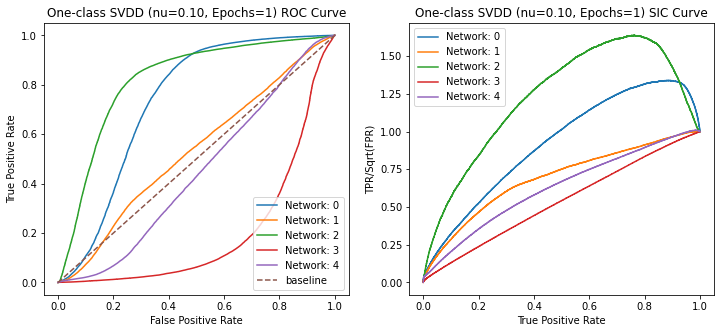

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, oc_svdd_scores, y_test, "One-class SVDD (nu=0.10, Epochs=1)")
fig.show()

### Soft-boundary Deep SVDD

In [29]:
sb_svdd_scores = []
epochs = 1 # epochs = 5 for LHCO data
models = [DeepSVDD('soft-boundary', nu=0.15) for _ in range(5)]

for model in models:
    model.set_network(base_net)
    # Also note for LHCO data you probably want to run on gpu
    model.train(svdd_data_loader, n_epochs=epochs, device="cpu")
    model.test(svdd_data_loader)
    _, _, scores = zip(*model.results['test_scores'])
    sb_svdd_scores.append(np.array(scores))

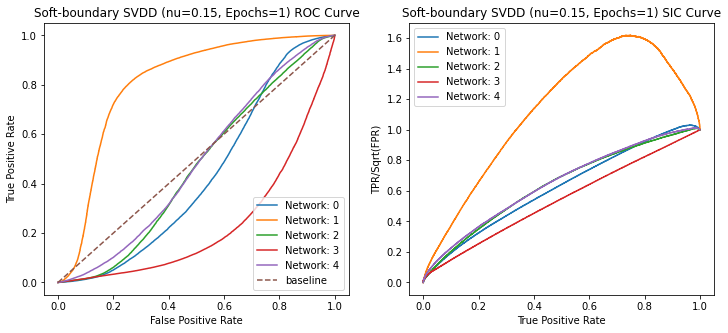

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
make_plots(ax1, ax2, sb_svdd_scores, y_test, "Soft-boundary SVDD (nu=0.15, Epochs=1)")
fig.show()